## Model Iteration 1

### Data Cleaning

In [182]:
import pandas as pd
df = pd.read_csv('data/train.csv')
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Let's first check for columns with missing values.

In [183]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Since the **Age** column is missing data, let's impute it with the median value.

In [184]:
def clean_age(data_frame):
    data_frame['Age'] = data_frame.Age.fillna(data_frame.Age.median())

The next significant feature is **Sex**.

In [185]:
df.Sex.unique()

array(['male', 'female'], dtype=object)

Let's convert Sex to an binary representation.

In [186]:
def clean_sex(data_frame):
    data_frame['Sex'] = data_frame.Sex.apply(lambda sex: int(sex == 'female'))

The next feature is **Embarked**.

In [187]:
df.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [188]:
def clean_embarked(data_frame):
    data_frame['Embarked'] = data_frame.Embarked.fillna(data_frame.Embarked.mode().values[0])

    mapping = {'S': 1, 'C': 2, 'Q': 3}
    data_frame['Embarked'] = data_frame.Embarked.apply(lambda port: mapping[port])

In [189]:
def clean_data(data_frame):
    clean_age(data_frame)
    clean_sex(data_frame)
    clean_embarked(data_frame)
    
clean_data(df)

### Learning

#### Cross Validation

In [190]:
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression

def cross_validate(data_frame, predictors):
    # Use the LogisticRegression classifier
    clf = LogisticRegression()
    
    X = data_frame[predictors]
    y = df.Survived
    
    # Cross validate over three folds
    scores = cross_validation.cross_val_score(clf, X, y, cv=3)
    return scores.mean()

predictors = ['Sex', 'Age', 'Pclass']
score = cross_validate(df, predictors)

print score

0.789001122334


#### Predict

In [191]:
# Read the data
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')

# Clean the training data
clean_data(train)

# Train
clf = LogisticRegression()
clf.fit(train[predictors], train.Survived)

# Clean the test data
clean_data(test)

# Predict
y_pred = clf.predict(test[predictors])

# Record Results
results = pd.DataFrame({
    'PassengerId': test.PassengerId,
    'Survived': y_pred        
})

results.to_csv('results.csv', index=False)

Kaggle Results: 0.76077

### Revision 1

In this revision I'll separate the embarked column into three dummy columns, one for each port.

In [192]:
train = pd.read_csv('data/train.csv')
clean_data(train)

In [193]:
def make_embarked_dummy(data_frame):
    data_frame['EmbarkedS'] = data_frame['EmbarkedC'] = data_frame['EmbarkedQ'] = 0
    
    data_frame.loc[data_frame.Embarked == 1, 'EmbarkedS'] = 1
    data_frame.loc[data_frame.Embarked == 2, 'EmbarkedC'] = 1
    data_frame.loc[data_frame.Embarked == 3, 'EmbarkedQ'] = 1

make_embarked_dummy(train)

Is there any improvement in the cross validation score?

In [194]:
predictors = ['Sex', 'Age', 'Pclass', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']
score_with_dummies = cross_validate(train, predictors)

print "Score: %f, Improvement: %f" % (score_with_dummies, score_with_dummies - score)

Score: 0.786756, Improvement: -0.002245


Unfortunately, the score did not improve. The additional features may have added increased dimensional complexity without providing much useful information.

In [195]:
# Read the data
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')

# Clean the training data
clean_data(train)
           
# Make the dummy columns
make_embarked_dummy(train)

# Train
clf = LogisticRegression()
clf.fit(train[predictors], train.Survived)

# Clean the test data
clean_data(test)
           
# Make the dummy columns
make_embarked_dummy(test)

# Predict
y_pred = clf.predict(test[predictors])

# Record Results
results = pd.DataFrame({
    'PassengerId': test.PassengerId,
    'Survived': y_pred        
})

results.to_csv('results.csv', index=False)

Kaggle Results: 0.74641, Improvement: -0.014

### Revision 2

It appears that squaring SibSp may make the survival rates more linear.

8


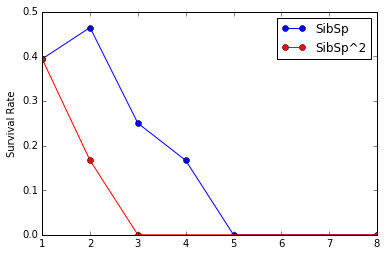

In [214]:
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

x = train.SibSp
print x.max()
bins = np.linspace(x.min(), x.max(), 8)

grouped = df.groupby(np.digitize(x, bins))
survival_rates = grouped.Survived.mean()

plt.plot(survival_rates, 'bo-')

x = train.SibSp.apply(lambda x: x**2)
bins = np.linspace(x.min(), x.max(), 8)

grouped = df.groupby(np.digitize(x, bins))
survival_rates = grouped.Survived.mean()

plt.plot(survival_rates, 'ro-')

plt.legend(['SibSp', 'SibSp^2'])
plt.ylabel('Survival Rate')
plt.show()

In [197]:
train = pd.read_csv('data/train.csv')
clean_data(train)

In [198]:
train['SibSp2'] = train.SibSp ** 2

In [199]:
predictors = ['Sex', 'Age', 'Pclass', 'SibSp2']
score_sq_sibsp = cross_validate(train, predictors)

print "Score: %f, Improvement: %f" % (score_sq_sibsp, score_sq_sibsp - score)

Score: 0.794613, Improvement: 0.005612


In [203]:
# Read the data
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')

# Clean the training data
clean_data(train)
           
# Square SibSp
train['SibSp2'] = train.SibSp ** 2

# Train
clf = LogisticRegression()
clf.fit(train[predictors], train.Survived)

# Clean the test data
clean_data(test)
           
# Square SibSp
test['SibSp2'] = test.SibSp ** 2

# Predict
y_pred = clf.predict(test[predictors])

# Record Results
results = pd.DataFrame({
    'PassengerId': test.PassengerId,
    'Survived': y_pred        
})

results.to_csv('results.csv', index=False)

Kaggle Results: 0.75120, Improvement: -0.0095